In [1]:
import os
import pickle
from tqdm.notebook import tqdm
import sentencepiece as spm

In [3]:
# we make data from scratch (ie WebQSP dump)
source_folder = '/scratche/home/apoorv/freebase/ComplexWebQuestions'
! ls {source_folder}

ComplexWebQuestions_dev.json   ComplexWebQuestions_train.json
ComplexWebQuestions_test.json


In [4]:
import json
fname = os.path.join(source_folder, 'ComplexWebQuestions_train.json')
train = json.load(open(fname))
fname = os.path.join(source_folder, 'ComplexWebQuestions_test.json')
test = json.load(open(fname))
fname = os.path.join(source_folder, 'ComplexWebQuestions_dev.json')
dev = json.load(open(fname))

In [6]:
# fname = 'data/fbwq_full/ent_map_fbwq_half_lego.pickle'
# entity_map = pickle.load(open(fname, 'rb'))
# fname = 'data/fbwq_full/rel_map_fbwq_half_lego.pickle'
# relation_map = pickle.load(open(fname, 'rb'))

In [15]:
train[2]

{'ID': 'WebQTrn-2360_a40a0d50b9a1006e2d254705d46345ea',
 'answers': [{'aliases': ['University of Florida Gators Mens Football',
    'Gators Mens Football',
    'Florida Gators Football',
    "Gators Men's Football",
    'University of Florida Mens Football',
    'University of Florida Football',
    "Florida Men's Football",
    'UF Gators Mens Football',
    "University of Florida Gators Men's Football",
    'UF Mens Football',
    "University of Florida Men's Football",
    'Gators Football',
    'UF Gators Football',
    'University of Florida Gators Football',
    "UF Gators Men's Football",
    'UF Football',
    "Florida Gators Men's Football",
    'Florida Football',
    'Florida Mens Football',
    'Florida Gators Mens Football',
    "UF Men's Football"],
   'answer': 'Florida Gators football',
   'answer_id': 'm.0ftf0f'}],
 'composition_answer': '',
 'compositionality_type': 'conjunction',
 'created': '2018-02-12T23:49:23',
 'machine_question': 'what football teams did emmitt 

In [13]:
webqsp_questions = set()
for q in train + test + dev:
    webqsp_questions.add(q['webqsp_question'])
len(webqsp_questions)

3443

In [14]:
len(test)

3531

In [29]:
from unidecode import unidecode

def normalize_string(s):
    s = unidecode(s)
    s = s.lower()
    return s

def makeQuestion(question):
    q_text = question['question']
    q_text = normalize_string(q_text)
    answers = []
    for a in question['answers']:
        ans = a['answer']
        if ans == None:
            ans = a['answer_id']
            print(ans, q_text)
        ans = normalize_string(ans)
        answers.append(ans)
    answers_string = '|'.join(answers)
    final_string = q_text + '\t' + answers_string
    return final_string

In [30]:
from tqdm.notebook import tqdm
train_lines = []
for q in tqdm(train):
    out = makeQuestion(q)
    train_lines.append(out)

  0%|          | 0/27639 [00:00<?, ?it/s]

1892-01-11 what year did the graduate form poland academy become the president?
1897-03-04 what year did the graduate form poland academy become the president?
1957-03-25 which country includes the president of the european council and is a member of the organization?
1973-01-01 which country includes the president of the european council and is a member of the organization?
1981-01-01 which country includes the president of the european council and is a member of the organization?
1986-01-01 which country includes the president of the european council and is a member of the organization?
1995-01-01 which country includes the president of the european council and is a member of the organization?
2004-05-01 which country includes the president of the european council and is a member of the organization?
2007-01-01 which country includes the president of the european council and is a member of the organization?
2013-07-01 which country includes the president of the european council and i

In [31]:
dev_lines = []
for q in tqdm(dev):
    out = makeQuestion(q)
    dev_lines.append(out)

  0%|          | 0/3519 [00:00<?, ?it/s]

In [44]:
test_lines = []
for id, q in enumerate(test):
    q['answers'] = []
    out = makeQuestion(q)
    test_lines.append(out)

In [48]:
train_lines[:10]

["what state is home to the university that is represented in sports by george washington colonials men's basketball?\twashington, d.c.",
 'what year did the team with baltimore fight song win the superbowl?\tsuper bowl xlvii|super bowl xxxv',
 'which school with the fight song "the orange and blue" did emmitt smith play for?\tflorida gators football',
 "what movie with film character named mr. woodson did tupac star in?\tgridlock'd",
 'what country sharing borders with spain does the setaobal district belong to?\tportugal',
 'who was the 1996 coach of the team owned by jerry jones?\tbarry switzer',
 'who dated the performer who headlined the concert tour called demi world tour?\tnicholas braun|joe jonas|cody linley',
 'which team owned by malcolm glazer has tim howard playing for it?\tmanchester united f.c.',
 'what movie starring zac efron that has a character named owen lars?\trobot chicken: star wars episode iii',
 'what business titles was the most famous alumni of detroit busines

In [47]:
dev_lines[0]

'who was the president in 1980 of the country that has azad kashmir?\tmuhammad zia-ul-haq'

In [51]:
test_lines[3]

'what country bordering france contains an airport that serves nijmegen?\t'

In [37]:
def writeLines(lines, fname):
    f = open(fname, 'w')
    for line in lines:
        f.write(line + '\n')
    f.close()

In [38]:
fname = 'data/cwq_half/qa_train_1hop.txt'
writeLines(train_lines, fname)
fname = 'data/cwq_half/qa_test_1hop.txt'
writeLines(dev_lines, fname)

In [52]:
fname = 'data/cwq_half/qa_test_actual_1hop.txt'
writeLines(test_lines, fname)

In [22]:
def getUniqueMap(init_map):
    out_map = {}
    values = set()
    for key, value in init_map.items():
        if value not in values:
            out_map[key] = value
            values.add(value)
        else:
            id_to_append = 0
            new_value = value + ' ' + str(id_to_append)
            while(new_value in values):
                id_to_append += 1
                new_value = value + ' ' + str(id_to_append)
            out_map[key] = new_value
            values.add(new_value)
    assert len(init_map) == len(set(out_map.values()))
    return out_map

def mapTriple(triple, ent_map, rel_map):
    t = triple
    new_triple = [ent_map[t[0]], rel_map[t[1]], ent_map[t[2]]]
    return new_triple

In [23]:
# uniq_ent_map = getUniqueMap(entity_map)
uniq_ent_map = entity_map

In [24]:
mapTriple(data['train'][0], uniq_ent_map, relation_map)

['Arthur Kingscote', 'place of death', 'Fulham']

In [15]:
out_folder = '/scratche/home/apoorv/transformer-kgc/data/MetaQA'
splits = ['train', 'test', 'valid']
for split in splits:
    fname = os.path.join(out_folder, split + '.txt')
    f = open(fname, 'w')
    triples = data[split]
    for t in triples:
        t = mapTriple(t, uniq_ent_map, relation_map)
        head, relation, tail = t
        input = 'predict tail: {0} | {1} |'.format(head, relation)
        output = '{}'.format(tail)
        f.write(input + '\t' + output + '\n')
        
        input = 'predict head: {0} | {1} |'.format(tail, relation)
        output = '{}'.format(head)
        f.write(input + '\t' + output + '\n')
    f.close()

In [16]:
# create entity_strings.txt which is needed in evaluation code
strings_file_name = 'entity_strings.txt'
f = open(os.path.join(out_folder, strings_file_name), 'w')
ents_uniq = set(uniq_ent_map.values())
for e in ents_uniq:
    f.write(e + '\n')
f.close()

In [17]:
def readQALines(fname):
    f = open(fname)
    questions = []
    for line in f:
        line = line.strip().split('\t')
        q = line[0]
        q = q.replace('[', '')
        q = q.replace(']', '')
        q = normalizeEntity(q)
        questions.append(q)
    return questions
        
def writeLines(lines, fname):
    f = open(fname, 'w')
    for line in lines:
        f.write(line + '\n')


In [18]:
fname = 'data/MetaQA/full_qa.txt'
questions = readQALines(fname)

In [19]:
fname = 'data/MetaQA/full_q_only.txt'
writeLines(questions, fname)

In [ ]:
vocab_size = 20000
sp = spm.SentencePieceTrainer.train(input='data/MetaQA/full_for_sp_train.txt', 
                                    model_prefix='metaqa_with_pad', vocab_size=vocab_size, 
                                    pad_id=3,
#                                     character_coverage=1.0,
#                                user_defined_symbols=['<pad>'],
#                                     normalization_rule_name='identity',
                              )

In [21]:
sp = spm.SentencePieceProcessor(model_file='data/sentencepiece/metaqa_with_pad.model')

In [22]:
sp['|']

5

In [39]:
sp.encode('about')

[4, 8811, 37]

In [92]:
lengths = []
for e in ents_uniq:
    encoded = sp.encode(e)
    lengths.append(len(encoded))

Text(0.5, 0, 'Tokenized lengths')

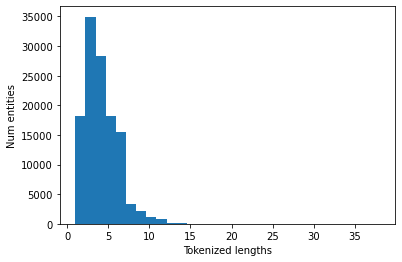

In [93]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [94]:
sp.encode('plays for')

[19, 13, 18]

In [35]:
from unidecode import unidecode
entities_ud = []
entities_ud_set = set()
for e in entities:
    ud_e = unidecode(e)
    entities_ud.append(ud_e)
    if ud_e in entities_ud_set:
        print(e, ud_e)
    else:
        entities_ud_set.add(ud_e)

University_of_Illinois_at_Urbana-Champaign University_of_Illinois_at_Urbana-Champaign
Hoang_Anh_Gia_Lai_F.C. Hoang_Anh_Gia_Lai_F.C.
Zurich Zurich
Toshirō_Mifune Toshiro_Mifune
Karl_Weierstrass Karl_Weierstrass
László_Bálint Laszlo_Balint
Sergio_Araujo Sergio_Araujo
Carlos_Tevez Carlos_Tevez
Polish-Lithuanian_Commonwealth Polish-Lithuanian_Commonwealth
Przemysl_II Przemysl_II
Christian_Groß Christian_Gross
Izmir Izmir
Münster Munster
Dalibor_Stevanovič Dalibor_Stevanovic
Jürgen_Gjasula Jurgen_Gjasula
Sócrates Socrates
Zlatko_Dedič Zlatko_Dedic
Antônio_Bezerra_Brandão Antonio_Bezerra_Brandao
Aleksander_Kwasniewski Aleksander_Kwasniewski
Sani_Bečirović Sani_Becirovic
Izmit Izmit
Ryukyu_Islands Ryukyu_Islands
Stanisław_Ulam Stanislaw_Ulam
Pantheon-Assas_University Pantheon-Assas_University
Quang_Binh_Province Quang_Binh_Province
Mures_County Mures_County
Braila Braila
San_Sebastian San_Sebastian
Ploiesti Ploiesti
Beja Beja
Zé_Antônio Ze_Antonio
San_Miguel_de_Tucumán San_Miguel_de_Tucuman
F

In [28]:
len(entities), len(set(entities))

(123182, 123182)

In [33]:
len(entities_ud), len(set(entities_ud))

(123182, 123145)